# I. Introduction

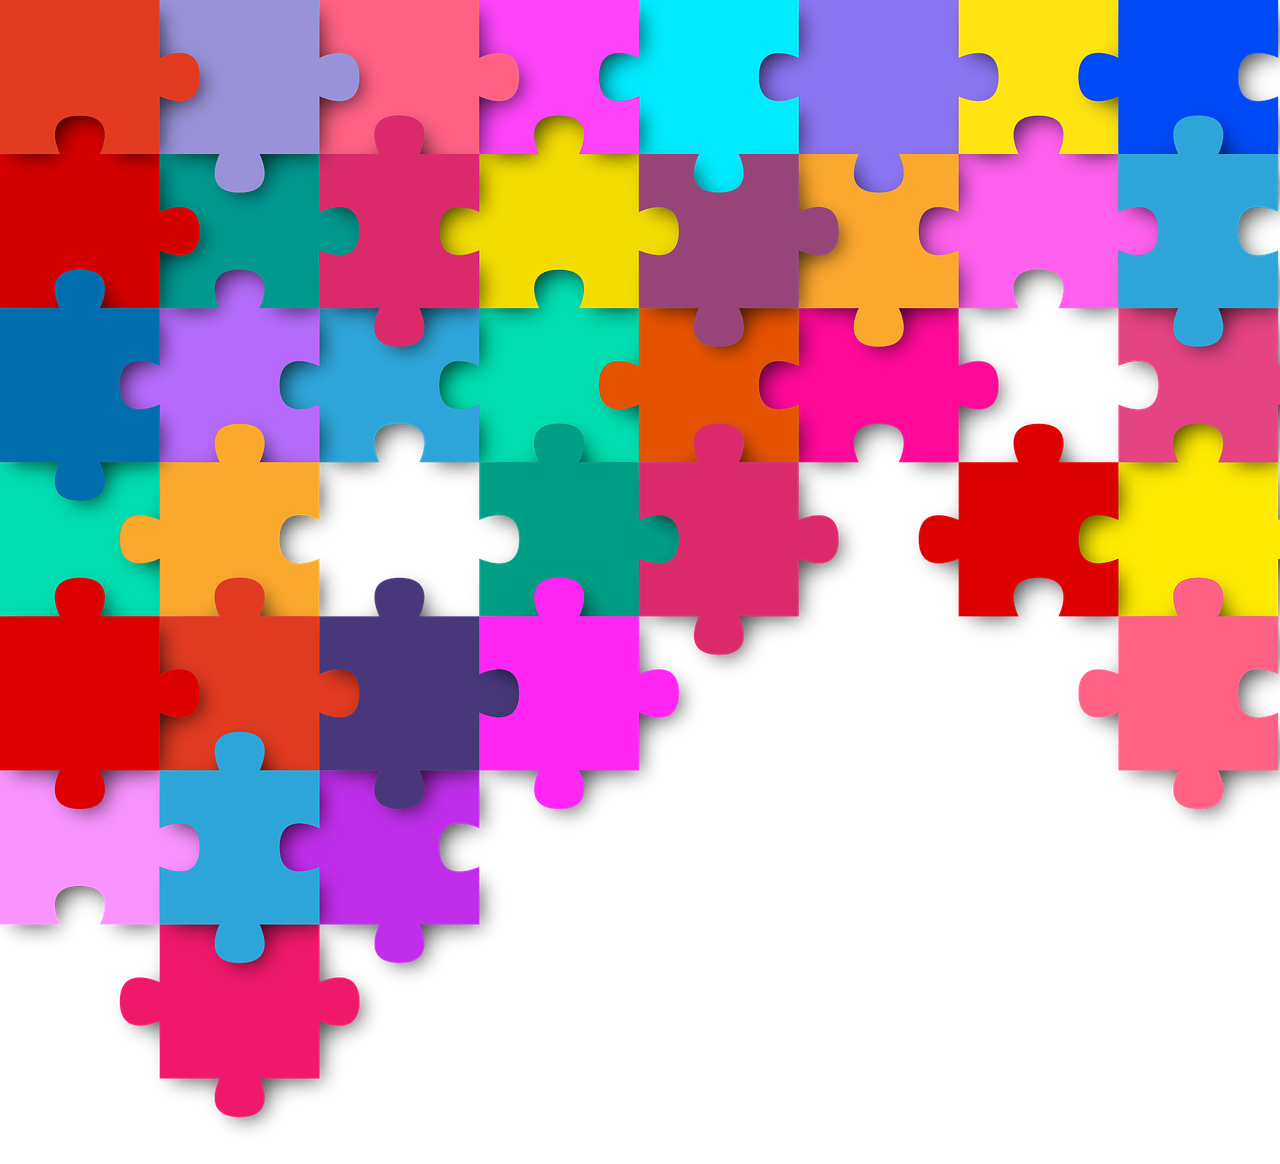

In [3]:
from IPython.display import Image
from IPython.core.display import HTML
path = '/Users/admin/Documents/puzzle.png'
Image(filename = path, width=300, height=300)

In the first notebook https://github.com/innawendell/Final_Capstone/blob/master/Ads%20(1).ipynb, we already built a recommendation model that could find the best matching titles for our ads from a databse of existing titles. Now, it is time for some experimentation: we will engage in the exciting task of `text generation`  and will try to make a recurrent neural network that will be able to generate an ads from scratch. 

# II. Our Approach

To tackle this problem, we will use a recurrent neural network because these networks are particularly good for working with sequences. RNNs process “sequences explicitly as sequences”. In our case, we can feed a sequence of word vectors to it, one word vector at a time and not a sequence all at once (as we would do with other models). RNNs also have a unique ‘memory’ aspect to them: they ‘remember’ information from the beginning of the sequence which makes them ideal for text generation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
import gensim
from gensim.models import word2vec
import re
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')
from collections import Counter

from keras.layers import Dense, Input, Embedding, Dropout, GRU, Bidirectional, LSTM
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


# III. Loading and Preprocessing The Data

At this point we will: 
- Remove punctuation from our texts and change them to lower case. It is important to mention that we will not lemmatize the texts because it is crucial for our model to learn the correct grammar usages from the data. So, for example, Russian nouns have six case forms in the singular and six case forms in the plural (twelve total). It will be very interesting to see if our Recurrent Neural Network can handle it. 
- Delete any duplicate entries.

In [2]:
ads = pd.read_csv('/Users/admin/Documents/contextAdvertising1.csv')

In [3]:
ads.head()

,atitle,atext,adomain
0,Клуб активного отдыха «0.67»,Детский пейнтбол. Спортивный пейнтбол. Тактиче...,0-67.relax.by
1,Антигравитационный чехол IPhone 5,Успейте купить антигравитационный чехол для IP...,0-antigravity.ru
2,Антигравитационный чехол купить!,Антигравитационный чехол для телефона купить з...,0-antigravity.ru
3,Беспроцентный заем от Moneyveo,Без справок! Получите до 3 000 грн. на карту п...,0-credit.moneyveo.ua
4,Беспроцентный заем сотруднику,Акция! Получите Кредит Онлайн под 0%. Без Спра...,0-credit.moneyveo.ua


In [4]:
ads.shape

(799999, 3)

In [5]:
ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799999 entries, 0 to 799998
Data columns (total 3 columns):
atitle     799999 non-null object
atext      799983 non-null object
adomain    799999 non-null object
dtypes: object(3)
memory usage: 18.3+ MB


In [6]:
ads.head()

,atitle,atext,adomain
0,Клуб активного отдыха «0.67»,Детский пейнтбол. Спортивный пейнтбол. Тактиче...,0-67.relax.by
1,Антигравитационный чехол IPhone 5,Успейте купить антигравитационный чехол для IP...,0-antigravity.ru
2,Антигравитационный чехол купить!,Антигравитационный чехол для телефона купить з...,0-antigravity.ru
3,Беспроцентный заем от Moneyveo,Без справок! Получите до 3 000 грн. на карту п...,0-credit.moneyveo.ua
4,Беспроцентный заем сотруднику,Акция! Получите Кредит Онлайн под 0%. Без Спра...,0-credit.moneyveo.ua


At this point, it becomes important to remove all the punctuation signs, change all words to lowercase, and remove any white spaces that we might have. We will remove any duplicate texts that we might have in our data and split our text strings into lists of strings, so that they can be used for training word2vec model. 

### 1. Remove Punctuation

In [7]:
#include all the punctuation signs\n",
def punctuation_remover(row):
    punctuation = '!"#$&\'()*+,-./:;<=>?@[\\]^_`{|}~«»'
    
    punctuationNoPeriod = "[" + re.sub("\.","", punctuation) + "]"
    row = re.sub(punctuationNoPeriod, " ", str(row))
    #to remove double white spaces and create space after %,
    row = row.replace('  ', ' ')
    row = row.replace('%', '% ')
    return row.strip()

In [8]:
# remove punctuation from the ads text
ads['atext'] = ads['atext'].apply(punctuation_remover)

In [9]:
# remove punctuation from the ads text
ads['atitle'] = ads['atitle'].apply(punctuation_remover)

In [10]:
ads.nunique()

atitle     557981
atext      348409
adomain     19181
dtype: int64

In [11]:
(ads['atitle'] + ads['atext']).nunique()

789564

In [12]:
def text_parser_first(series): 
    series_copy = series.copy()
    list_of_strings = []
    for row in series:
        row= row.lower().strip()      
        list_of_strings.append(row)
    return list_of_strings

In [13]:
ads['atitle'] = text_parser_first(ads['atitle'])

In [14]:
ads['atext'] = text_parser_first(ads['atext'])

### 2. Drop Any Duplicate Entries

In [15]:
unique =ads.drop_duplicates(subset = ['atext'], keep=False)

In [16]:
unique =unique.drop_duplicates(subset = ['atitle'], keep=False)

In [17]:
unique = unique.drop_duplicates(keep=False)

In [18]:
unique.nunique()

atitle     192694
atext      192694
adomain      4465
dtype: int64

In [19]:
unique.shape

(192694, 3)

In [20]:
def text_parser_second(series): 
    series_copy = series.copy()
    list_of_strings = []
    for row in series:
        row= row.split()      
        list_of_strings.append(row)
    return list_of_strings

In [21]:
split_ads = unique.copy()

In [22]:
split_ads.shape

(192694, 3)

In [23]:
split_ads['atitle'] = text_parser_second(unique['atitle'])

In [24]:
split_ads['atext'] = text_parser_second(unique['atext'])

In [25]:
split_ads.head()

,atitle,atext,adomain
0,"[клуб, активного, отдыха, 0, 67]","[детский, пейнтбол, спортивный, пейнтбол, такт...",0-67.relax.by
1,"[антигравитационный, чехол, iphone, 5]","[успейте, купить, антигравитационный, чехол, д...",0-antigravity.ru
3,"[беспроцентный, заем, от, moneyveo]","[без, справок, получите, до, 3, 000, грн, на, ...",0-credit.moneyveo.ua
4,"[беспроцентный, заем, сотруднику]","[акция, получите, кредит, онлайн, под, 0%, без...",0-credit.moneyveo.ua
11,"[аnti, gravity, case]","[аnti, gravity, case, –, уникальный, антиграви...",0-gravity.online-shop-2017.ru


In [26]:
split_ads.iloc[10, 0]

['нужен', 'бухгалтер']

In [27]:
split_ads.iloc[10, 1]

['бухгалтер', 'под', 'ключ', 'дешево']

In [28]:
split_ads['combined'] = split_ads['atext'] +split_ads['atitle']

# IV. Train Word2Vec 

Now, we will proceed to:
- Train Word2Vec model and evaluate it by a) checking most similar words to a random word (‘computer’) and b) creating a t-SNE plot and visually inspecting it.
- Split our ads texts into training and test examples to be used for model training and evaluation.
- Limit our vocabulary to the most frequently used words (this is not a requirement but rather a limitation that is caused by computational power of my local machine).

Our decision to train word2vec model on both ad texts and ad titles stems from the fact that, if we had a pretrained model at hand, it would have been trained on a very large corpus. We will need to evaluate our word2vec model. Here, we will check its performance by looking at the most similar words to the word "computer". The results include other case forms of the word "computer" ('компьютере', 'компьютера') which makes sense. 

In [29]:
model_w2v = word2vec.Word2Vec(
    split_ads['combined'],
    workers=4,     
    min_count=15,   
    window=30,      
    sg=0,          
    sample=1e-3 ,  
    size=100,      
    hs=1           
)

In [30]:
word_vectors = model_w2v.wv

In [31]:
vocabulary = model_w2v.wv.vocab.keys()
print(len(vocabulary))

13613


### 1. Closest Word Vectors

In [32]:
model_w2v.wv.most_similar_cosmul(positive=['компьютер'])

[('компьютере', 0.7363376617431641),
 ('то', 0.6972121596336365),
 ('компьютера', 0.6941441893577576),
 ('4xddr3', 0.6882896423339844),
 ('прочистка', 0.6874386668205261),
 ('пройти', 0.6871018409729004),
 ('струйный', 0.6861037015914917),
 ('smart', 0.6846106648445129),
 ('купим', 0.684134304523468),
 ('1200x1200', 0.6828628182411194)]

### 2.  T-SNE Plot 

Another useful way to analyze our word2vec model is visual inspection of the t-SNE plot. In our case, it shows that the model was able to learn important similarities (e.g. ‘hotel’, another case of 'hotel,' and ‘inn’ are almost overlapping, whereas‘asus’, 'acer', 'dell,' and 'hp' are very close to one another). 


In [33]:
def tsne_plot(model):
    #Creates and TSNE model and plots it
    
    labels = []
    tokens = []

    for word in model.wv.vocab:
        if model.wv.vocab[word].count > 1000:
            tokens.append(model[word])
            labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=108)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

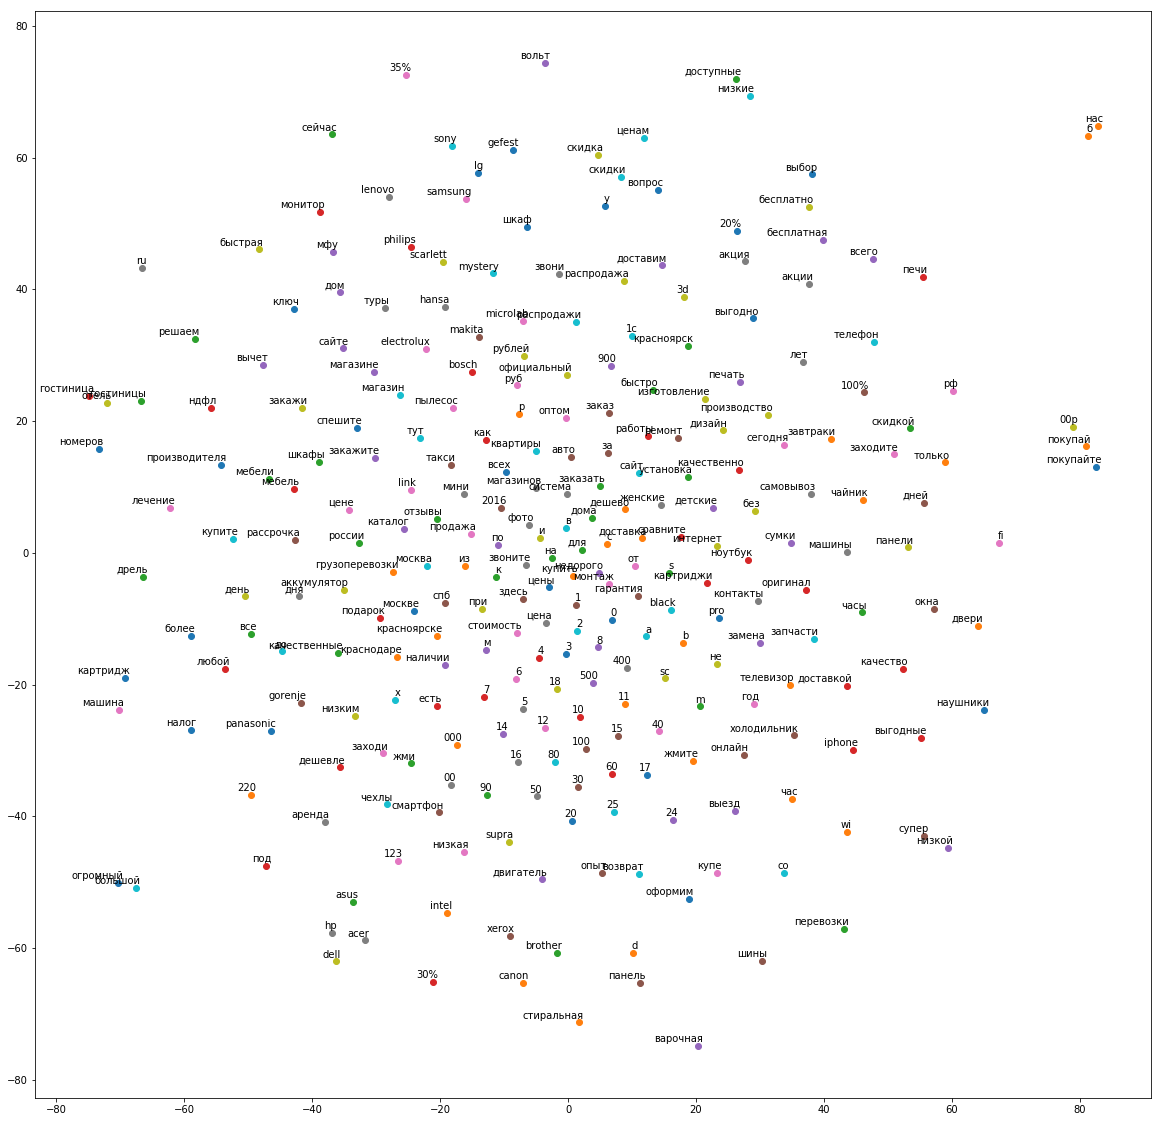

In [34]:
tsne_plot(model_w2v)

# V. Train-Test Split

In [35]:
X = split_ads['atext']

In [36]:
X_train, X_test = train_test_split(X, test_size=0.3, random_state=0)

In [37]:
len(X_train)

134885

In [38]:
len(X_test)

57809

Our computational limitations made it necessary to restrict our vocabulary only to `the most frequently used words.` For these, we will create individual indices and convert texts into sequences of indices.
Words that are not in our vocabulary will be marked by ‘-1’ and later removed from the sequences.


# VI. Recurrent Neural Network 

**RNN-specific steps** will include:
- Creation of individual indices for each word in our narrowed-down vocabulary.
- Conversion of our texts into sequences of indices.
- Turning our sequences into n-grams.
- Creation of padded sequences, predictors, and labels.
- Creation of an embeddings matrix
- Training of our RNN model

### 1. Word Count. Creation of Word Indices

In [39]:
MAX_NB_WORDS = len(vocabulary)

In [40]:
MAX_NB_WORDS

13613

In [41]:
vocab=Counter()

for entry in X_train:
    vocab.update(entry)

In [42]:
len(vocab)

80569

In [43]:
word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}

In [44]:
for i in X_train.iloc[2]:
    print(i)

купить
dell
монитор
dell
se2416h
416h
2078
жк
мониторы
23


### 2. Creation of Sequences of Indices

We are ready to turn our word sequences into sequences of indices. However, as you can remeber, we did not include every word into our vocabulary, only the most frequently used words. It makes sense to mark these words that are not in our vocabulary by '-1' and then remove them from our sequences, so that they do not have a negative impact on the predicted words.

In [45]:
training_sequences = [[word_index.get(t, -1) for t in ad_text]
             for ad_text in X_train]

In [46]:
test_sequences = [[word_index.get(t, -1) for t in ad_text]
             for ad_text in X_test]

In [47]:
def back_transformer(input):
    larger_rows =[]
    for index, row in enumerate(input):
        new_rows =[]
        for num, ind in enumerate(row):
            if num <=21 and ind!=-1:
                new_rows.append(ind)
        larger_rows.append(new_rows)
    return larger_rows

In [48]:
seqtr_training = back_transformer(training_sequences)
seqtr_test = back_transformer(test_sequences)

In [49]:
max([len(x) for x in seqtr_training])

21

In [50]:
max([len(x) for x in seqtr_test])

19

In [51]:
MAX_SEQUENCE_LENGTH = max([len(x) for x in seqtr_training])

### 3. N-Gram Generation

At this stage, we will create n-grams, from each indexed sequence, adding a one word at a time. This will be useful for us  if we wish to train a model that predicts the next word in sequence. 

In [52]:
def ngram_sequence_generator(input_text):
    ngram_inputs = []
    for entry in input_text:
        for i in range(1, len(entry)):
            ngram_seq = entry[:i+1]
            ngram_inputs.append(ngram_seq)
            
    return ngram_inputs

In [53]:
ngram_input_sequences_training = ngram_sequence_generator(seqtr_training)

In [54]:
ngram_input_sequences_test = ngram_sequence_generator(seqtr_test)

In [55]:
ngram_input_sequences_training[:20]

[[2382, 468],
 [2382, 468, 7],
 [2382, 468, 7, 1],
 [2382, 468, 7, 1, 5],
 [2382, 468, 7, 1, 5, 4],
 [2382, 468, 7, 1, 5, 4, 6],
 [4267, 135],
 [4267, 135, 118],
 [4267, 135, 118, 3295],
 [4267, 135, 118, 3295, 10],
 [4267, 135, 118, 3295, 10, 47],
 [4267, 135, 118, 3295, 10, 47, 208],
 [4267, 135, 118, 3295, 10, 47, 208, 198],
 [3, 207],
 [3, 207, 127],
 [3, 207, 127, 207],
 [3, 207, 127, 207, 274],
 [3, 207, 127, 207, 274, 291],
 [3, 207, 127, 207, 274, 291, 411],
 [187, 275]]

### 4. Padding. Creation of Predictors and Labels

Now, we are approaching the final stages of our pipeline. First, we will pad our n-gram sequences. Despite the fact that the ability to take sequences of any length is one of the main strength of RNN, the way Keras works makes it necessary for us to `create padded sequences` of the same length (max length). Then, we will split our padded sequences into `‘predictors’` and `‘labels’`. For example, for predictor [2382, 468], the label will be [7]. We will make all labels categorical (by using Keras’s ‘to_categorical’ which converts our class vector into binary class matrix which we can use with ‘categofical_crossentropy.’

In [57]:
def generate_padded_sequence(input_sequences):
    input_sequences = pad_sequences(input_sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre")
    predictors = []
    labels = []
    for i in range(len(input_sequences)-1):
        predictor = input_sequences[i]
        label = input_sequences[i+1][-1]
        label_cat = to_categorical(label, num_classes=MAX_NB_WORDS+1)
        predictors.append(predictor)
        labels.append(label_cat)
    
    #label = to_categorical(label, num_classes=MAX_NB_WORDS+1)
    return np.array(predictors), np.array(labels)

In [60]:
ngram_input_sequences_training[:20]

[[2382, 468],
 [2382, 468, 7],
 [2382, 468, 7, 1],
 [2382, 468, 7, 1, 5],
 [2382, 468, 7, 1, 5, 4],
 [2382, 468, 7, 1, 5, 4, 6],
 [4267, 135],
 [4267, 135, 118],
 [4267, 135, 118, 3295],
 [4267, 135, 118, 3295, 10],
 [4267, 135, 118, 3295, 10, 47],
 [4267, 135, 118, 3295, 10, 47, 208],
 [4267, 135, 118, 3295, 10, 47, 208, 198],
 [3, 207],
 [3, 207, 127],
 [3, 207, 127, 207],
 [3, 207, 127, 207, 274],
 [3, 207, 127, 207, 274, 291],
 [3, 207, 127, 207, 274, 291, 411],
 [187, 275]]

In [61]:
predictors_tr_s, label_tr_s = generate_padded_sequence(ngram_input_sequences_training)

In [62]:
predictors_test_s, label_test_s = generate_padded_sequence(ngram_input_sequences_test)

### 5. Creation of Embedding Matrix

At this point, will create embeddings matrix that will hold word vector values for each indexed word from our most frequently used words. This embeddings matrix will later be used in the Keras Embeddings layer (to be used in ‘weights’).

In [63]:
length_maxtrix = len(vocabulary)+1

embedding_matrix = np.zeros((length_maxtrix, 100))

for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
            continue
    try:        
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        if embedding_vector is not None:  
            embedding_matrix[i] = embedding_vector
    except:
        pass

In [64]:
WV_DIM = 100

In [65]:
MAX_NB_WORDS

13613

### 6. Training Our Recurrent Neural Network

Now, we are ready to create recurrent neural network. In this case, for computational reasons, we used two GRU layers, 100 units each. In the future, it will be possible to increase both the number of layers and the number of units. We fit the model on our training examples of predictors and labels (‘the words to be predicted’) and test it on the test examples.

In [66]:
model_gen_larger = Sequential()
model_gen_larger.add(Embedding(MAX_NB_WORDS +1,
                     WV_DIM,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False))

model_gen_larger.add(GRU(100, return_sequences=True))
model_gen_larger.add(Dropout(0.2))
model_gen_larger.add(GRU(100))
model_gen_larger.add(Dropout(0.2))
model_gen_larger.add(BatchNormalization())
model_gen_larger.add(Dense(MAX_NB_WORDS+1, activation = 'softmax'))

model_gen_larger.compile(loss='categorical_crossentropy', 
                   optimizer = 'adam', 
                   metrics = ['accuracy']) 

In [67]:
model_gen_larger.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 21, 100)           1361400   
_________________________________________________________________
gru_1 (GRU)                  (None, 21, 100)           60300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 100)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 100)               60300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 13614)             1375014   
Total para

Now is the time for training: time for patience because training neural networks is notoriously time-consuming.

In [68]:
model_gen_larger.fit(predictors_tr_s, label_tr_s, 
               epochs = 30, 
               verbose=1,
               batch_size=300,
               shuffle=True,
               validation_data = (predictors_test_s, label_test_s))

Train on 1025471 samples, validate on 436028 samples
Epoch 1/30
1025471/1025471 [==============================] - 1011s 986us/step - loss: 4.6316 - acc: 0.3513 - val_loss: 3.6718 - val_acc: 0.4380
Epoch 2/30
1025471/1025471 [==============================] - 1072s 1ms/step - loss: 3.7565 - acc: 0.4220 - val_loss: 3.4513 - val_acc: 0.4628
Epoch 3/30
1025471/1025471 [==============================] - 1051s 1ms/step - loss: 3.5699 - acc: 0.4391 - val_loss: 3.3667 - val_acc: 0.4744
Epoch 4/30
1025471/1025471 [==============================] - 1077s 1ms/step - loss: 3.4736 - acc: 0.4479 - val_loss: 3.3205 - val_acc: 0.4809
Epoch 5/30
1025471/1025471 [==============================] - 1068s 1ms/step - loss: 3.4117 - acc: 0.4542 - val_loss: 3.2900 - val_acc: 0.4848
Epoch 6/30
1025471/1025471 [==============================] - 1187s 1ms/step - loss: 3.3696 - acc: 0.4576 - val_loss: 3.2723 - val_acc: 0.4885
Epoch 7/30
1025471/1025471 [==============================] - 1335s 1ms/step - loss: 3.

# VII. Text Generation

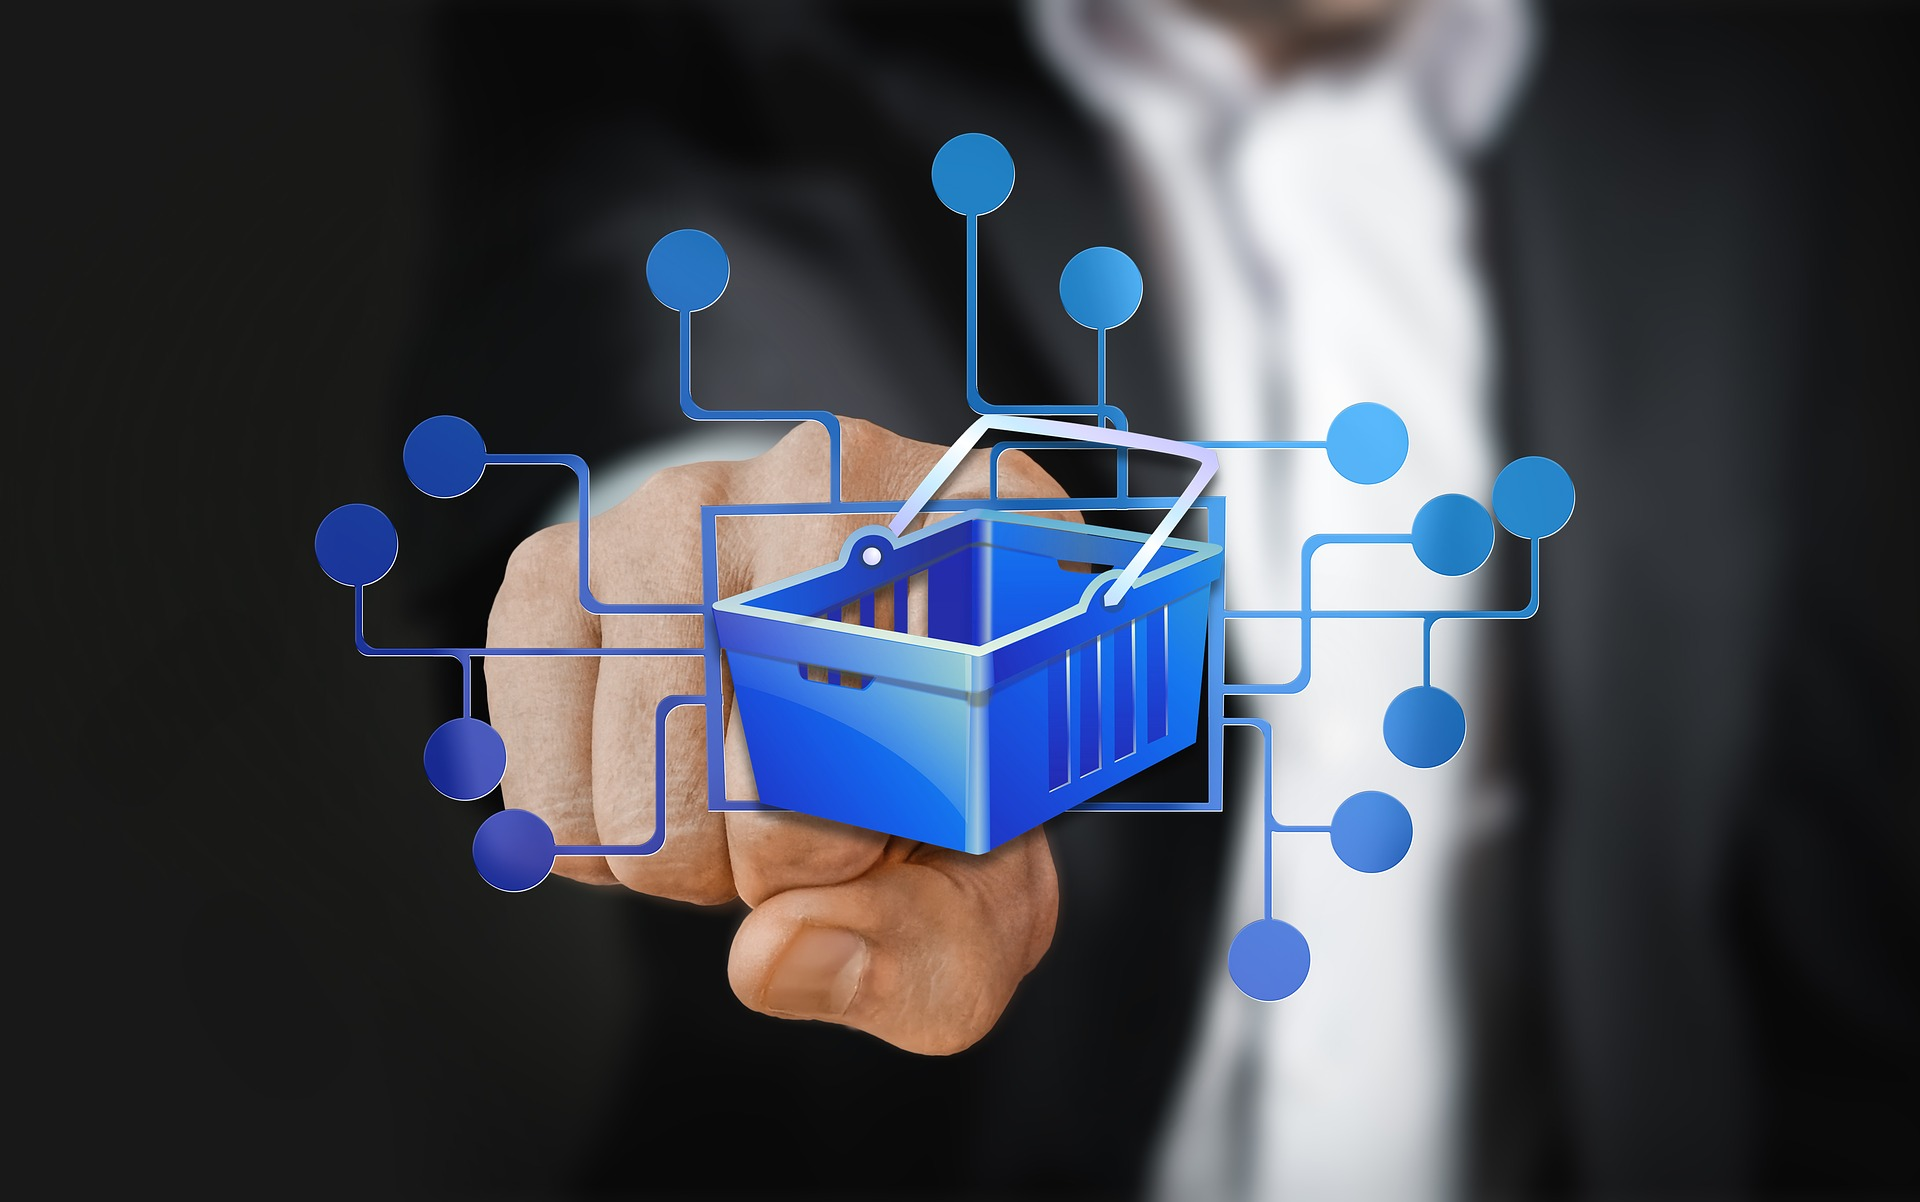

In [4]:
path = '/Users/admin/Documents/Automation.jpg'
Image(filename = path, width=600, height=300)

We are ready for some exciting experiments. We can generate ads. Let’s plug in some frequently advertised items and see what we get. 

In [69]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    output_sequence = ''
    for _ in range(next_words):
        seed_text = seed_text.lower()
        seed_list = seed_text.split()
        token_list = [word_index.get(word)for word in seed_list]
        
        token_list= pad_sequences([token_list], maxlen=MAX_SEQUENCE_LENGTH, padding="pre")
        predicted = model.predict_classes(token_list, verbose=0)
        #print(token_list, 'predicted', predicted)
        output_word = ""
        for word,index in word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    for word in seed_list:
        output_sequence+=word+ ' '
    return output_sequence.strip()

In [73]:
generate_text('двери', 20, model_gen_larger, 15)

'двери межкомнатные подарок установка или фурнитура для ванной комнаты установка и подарок выбор для дома и дома сравните цены всех'

Translation: 'interroom doors gift setup or accessories for (your) bathroom set up and gift choice for (your) home compare prices of all'

In [75]:
generate_text('цветы', 15, model_gen_larger, 15)

'цветы в москве в москве от 3500 руб за 3 дня успей от 3500 руб'

Translation: 'flowers in moscow in moscow from 3500 rubles in three days don't miss your chance from 3500 rubles'

In [106]:
generate_text('телефон', 15, model_gen_larger, 15)

'телефон от 00 доставка для авто в москве звоните от производителя в москве наличии от'

Translation: 'phone from 00 delivery for car in moscow call from manufacturer in moscow in stock from'

In [79]:
generate_text('телевизоры', 15, model_gen_larger, 15)

'телевизоры сравните цены всех интернет магазинов сравните цены всех интернет магазинов сравните цены всех интернет'

Translation: 'TV-sets compare prices of all online stores compare prices of all online stores compare prices of all online stores compare prices of all online stores'

In [157]:
generate_text('окна', 16, model_gen_larger, 15)

'окна в хабаровске от производителя скидка на все 5% бесплатная доставка сравните цены всех интернет магазинов'

Translation: 'windows in Khabarovsk from manufacturer 5% off everything free delivery compare prices of all online stores'

In [108]:
generate_text('стрижки', 15, model_gen_larger, 15)

'стрижки волос philips 10 низкая цена гарантия большой выбор быстрая доставка сравните цены всех интернет'

Translation: 'haircuts philips 10 low prices warranty large selection fast delivery compare prices of all online'

In [83]:
generate_text('машинка', 15, model_gen_larger, 15)

'машинка шлифовальная прямая bosch pws 125 ce 125 ce гарантия 100% покупай сравните цены всех'

Translation: 'polishing machine bosch pws 125 ce 125 125 ce warranty 100% buy compare prices of all'

In [112]:
generate_text('цены', 18, model_gen_larger, 15)

'цены от 2000 руб сут бронируйте отель без комиссии и переплат сравните цены всех интернет магазинов на сайте'

Translation: 'prices from 2000 rubles per night book a hotel without fees and extra charges compare prices of all online stores on the website'

In [91]:
generate_text('интернет', 20, model_gen_larger, 15)

'интернет магазин эротических костюмов бесплатная доставка по рб скидки и акции для вас сравните цены всех интернет магазинов сравните цены'

Translation: 'online store of adult clothing free delivery in Belarus discounts and promos for you compare prices of all online stores'

In [92]:
generate_text('отель', 20, model_gen_larger, 15)

'отель в чите wifi уютно удобно скидка 42% документы жмите от производителя hp hp 15 в 220 вольт сравните цены'

Translation: 'hotel in Chita wifi cozy convenient 42% off documents click (here) from manufacturer hp hp 15 (?) 220 volt compare prices'

In [94]:
generate_text('отели', 20, model_gen_larger, 15)

'отели в центре петербурга в центре города от 1200 р онлайн и в наличии за руб купить сравните цены всех'

Translation: 'hotels in downtown St. Petersburg from 1200 rubles online and in stock for rub. buy compare prices of all'

In [116]:
generate_text('шкаф', 15, model_gen_larger, 15)

'шкаф купе от производителя в краснодаре низкие цены распродажа в москве доставка по россии россии'

Translation: 'rolling door wardrobe from manufacturer in Krasnoyarsk low prices sales in Moscow delivery all across Russia across Russia'

In [117]:
generate_text('купите', 15, model_gen_larger, 15)

'купите утеплитель урса по выгодной цене гарантия доставка по рф сравните цены всех интернет магазинов'

Translation: 'ursa insulation good price warranty delivery across russia compare prices of all online stores'

In [119]:
generate_text('пылесос', 15, model_gen_larger, 15)

'пылесос bosch gas 24 24 р гарантия 100% покупайте для детей на сайте сравните цены'

Translation: 'vacuum cleaner bosch gas 24 24 r (rubles) warranty 100% buy for (your) children on the website compare prices'

In [121]:
generate_text('мебель', 15, model_gen_larger, 15)

'мебель для ванной сравните цены всех интернет магазинов на сайте сравните цены всех интернет магазинов'

Translation: 'bathroom furniture compare prices of all online stores compare prices of all online stores compare prices of all online stores'

In [122]:
generate_text('смартфон', 15, model_gen_larger, 15)

'смартфон samsung galaxy a5 2016 a510f 10р гарантия 100% сравните цены всех интернет магазинов сравните'

Translation: 'smartphone samsung galaxy a5 2016 a510f 10 r. (rubles) warranty 100% compare prices of all online stores compare'

In [123]:
generate_text('скидки', 15, model_gen_larger, 15)

'скидки 35% распродажи супер акции шок цены наличии на сайте сравните цены всех интернет магазинов'

Translation: 'discounts 35% sales super deals shockingly low prices in stock on the website compare prices of all online stores'

In [127]:
generate_text('скидка', 16, model_gen_larger, 15)

'скидка 10% на все 5% бесплатная доставка по россии для дома сравните цены всех интернет магазинов'

Translation: '10% off discount on everything 5% free delivery across russia for home compare prices of all online stores'

In [129]:
generate_text('распродажа', 15, model_gen_larger, 15)

'распродажа день пт подарок доставка рф от 2 дня жми сюда на сайте сравните цены'

Translation: 'sale day friday gift delivery russia from two days click here on the website compare prices'

In [131]:
generate_text('квартиры', 15, model_gen_larger, 15)

'квартиры в от застройщиков много объектов скидки от производителя низкие цены звоните от производителя производителя'

Translation: 'apartments in from the construction companies many locations discounts from the manufacturer low prices call from the manufacturer from the manufacturer'

In [132]:
generate_text('стиральная машина', 15, model_gen_larger, 15)

'стиральная машина lg f12u1hbs2 00 р гарантия 100% купите онлайн сравните цены всех интернет магазинов сравните'

In [135]:
generate_text('монтаж', 20, model_gen_larger, 15)

'монтаж натяжных потолков гарантия 12 лет установка и уборка за 2 часа рассрочка от 2 часа звоните от 400 руб'

In [137]:
generate_text('фотографии', 20, model_gen_larger, 15)

'фотографии с доставкой по москве и области в наличии и под заказ доставка по россии сравните цены всех интернет магазинов'

In [138]:
generate_text('фото', 20, model_gen_larger, 15)

'фото светильник с вау эффектом от 3200р жми в москве и области в москве и области по лучшим ценам в'

In [141]:
generate_text('перевозки', 15, model_gen_larger, 15)

'перевозки транспортная компания решаем вопрос перевозок от производителя в наличии сравните цены всех интернет магазинов'

In [142]:
generate_text('акции', 15, model_gen_larger, 15)

'акции от 1100 руб сут скидки завтраки отзывы контакты отеля bosch сравните цены всех интернет'

In [144]:
generate_text('такси', 15, model_gen_larger, 15)

'такси в аэропорт пулково от 125 р заказывайте дешевле в 220 вольт от производителя в'

In [145]:
generate_text('холодильник', 15, model_gen_larger, 15)

'холодильник waeco низкая цена доставка гарантия сравните цены всех интернет магазинов сравните цены всех интернет'

In [147]:
generate_text('мышка', 15, model_gen_larger, 15)

'мышка для геймера за руб доставка по россии от производителя в наличии и под заказ'

In [150]:
generate_text('ножи', 20, model_gen_larger, 15)

'ножи от 00 доставка в москве в москве доставка по россии звоните от производителя в москве наличии от производителя hp'

In [154]:
generate_text('стол', 15, model_gen_larger, 15)

'стол для кухни сравните цены всех интернет магазинов на сайте сравните цены всех интернет магазинов'

In [156]:
generate_text('продукты', 15, model_gen_larger, 15)

'продукты для дома в москве от производителя низкие цены и доставка для вас сравните цены'

In [158]:
generate_text('фен', 16, model_gen_larger, 15)

'фен philips низкая цена гарантия большой выбор быстрая доставка гарантия жми сравните цены всех интернет магазинов'

# VIII. Conclusion

Despite some noticable glitches (overuse of certain frequent phrases like `"compare prices of all internet stores",` `"directly from the manufacturer"` and `inappropriate insertion of words` ('hp' in texts about knives, apartments, and hotels and '220 volt' in a text about hotels, the model still looks `very promising` because it has managed to produce `grammatically correct forms` (e.g. the genitive case after the prepositions  "от" and "для"("from" and "for"), the prepositional case for "location". Additionally, it has `learned some frequently used catch phrases` within the advertising genre ("low prices", "warranty", "free delivery", "discounts", "sale", "10% off") 

As we continue developing this product in the future, it could become an integral part of an online advertisement platform that would give customers an option to auto-generate advertisements from scratch: fast, efficient, with no human labor involved. Additionally, we could develop a model that would be able to take product descriptions and make fully customized ads.  A nice side perk is that the same model can suggest the next word/s as a person is typing an ad (just like ‘smart compose’ in gmail which is only available in English). 